In [1]:
!CUDA_LAUNCH_BLOCKING=1

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_
import librosa
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

from torch import optim


In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = '?-*-*-*.wav'  # Как сохранена вавка
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 64
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 50
    sample_rate: int = 44_100
    n_fft = 1024
    win_length = 1024
    hop_length = 256
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    path2noise = r'C:\VS_code\Deep Learning\Audio\audio\Noise'
    train_ratio = 0.9
    length_wav = 220_500
    length = 862

In [4]:
length = torch.Tensor([np.round(TaskConfig.length_wav / TaskConfig.hop_length + 1)] * TaskConfig.batch_size).squeeze()

In [5]:
class ESC_50(Dataset):
    SR = TaskConfig.sample_rate
    """
    Каждый формат имеет следующую структуру:
        {FOLD}-{CLIP_ID}-{TAKE}-{TARGET}.wav

        * {FOLD} - index of the cross-validation fold,
        * {CLIP_ID} - ID of the original Freesound clip,
        * {TAKE} - letter disambiguating between different fragments from the same Freesound clip,
        * {TARGET} - class in numeric format [0, 49].   

    Здесь нас интересует только target)
    """
    def __init__(self, path2dir=None,transform=None,csv=None):
        self.transform=transform
        if csv is None:
            path2dir = pathlib.Path(path2dir)
            self.paths = list(path2dir.rglob(TaskConfig.keyword))
            twins = []
            for j in range(len(self.paths)):
                path_to_wav = self.paths[j].as_posix()
                label = int(path_to_wav.split('/')[-1].split('-')[-1].split('.')[0])
                twins.append((path_to_wav, label))
            self.csv = pd.DataFrame(
                twins,
                columns = ['path', 'label']
            )
        else:
            self.csv = csv
    
    def __getitem__(self, index):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0) # убираем размерность

        if self.transform:
            wav = self.transform(wav)

        return {
            'wav':wav,
            'label':instance['label']
        } 
        
    def __len__(self):
        return len(self.csv)
        
                

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = ESC_50(r'/content/drive/MyDrive/ESC-50')
data.csv
data.__getitem__(10)
data.__len__()

2000

# Augmentation

In [8]:
class AugsCreation:
    def __init__(self):
        self.background_noises = ['/content/drive/MyDrive/Noise/dude_miaowing.wav',
                                  '/content/drive/MyDrive/Noise/running_tap.wav',
                                  '/content/drive/MyDrive/Noise/pink_noise.wav',
                                  '/content/drive/MyDrive/Noise/exercise_bike.wav',
                                  '/content/drive/MyDrive/Noise/white_noise.wav']

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]
        noise_level = torch.Tensor([1])  # [0, 40]
        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)
        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]
        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            # lambda x: librosa.effects.time_stretch(x.numpy().squeeze(), 2.0)
            # lambda x: librosa.effects.pitch_shift(x.numpy().squeeze(), sr, -5)
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)

        ]

        return augs[aug_num](wav)

In [ ]:
# list_1 =list(pathlib.Path(r'/content/drive/MyDrive/Noise').rglob('*_*.wav'))
# list_2 = [j.as_posix() for j in list_1]
# list_2

['/content/drive/MyDrive/Noise/dude_miaowing.wav',
 '/content/drive/MyDrive/Noise/running_tap.wav',
 '/content/drive/MyDrive/Noise/pink_noise.wav',
 '/content/drive/MyDrive/Noise/exercise_bike.wav',
 '/content/drive/MyDrive/Noise/white_noise.wav']

In [9]:
indexes = torch.randperm(len(data))
tr = TaskConfig.train_ratio
train_indexes = indexes[:int(len(data) * tr)]
val_indexes = indexes[int(len(data) * tr):]

train_df = data.csv.iloc[train_indexes].reset_index(drop=True)
val_df = data.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
train_set = ESC_50(csv=train_df,transform=AugsCreation())
val_set = ESC_50(csv=val_df)

In [11]:
class Collator:
    def __call__(self, data):
        lengths = []
        wavs = []
        labels = []

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])
            lengths.append(len(el['wav']))

        wavs = pad_sequence(wavs, batch_first=True)
        labels = torch.Tensor(labels).long()
        length = torch.Tensor(lengths).long()
        return {
            'wav':wavs,
            'label': labels,
            'length': length
        }

In [ ]:
# # Взвесим каждый таргет на основании его длины 
# def get_sampler(target):
#     class_sample_count = np.array(
#         [len(np.where(target==t)[0]) for t in np.unique(target)])

#     weight = 1. / class_sample_count
#     samples_weight = np.array([weight[t] for t in target])
#     samples_weight = torch.from_numpy(samples_weight)
#     samples_weight = samples_weight.float()
#     sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
#     return sampler

# train_sampler = get_sampler(train_set.csv['label'].values)

Dataloaders

In [12]:
train_dataloader = DataLoader(
    train_set, batch_size=TaskConfig.batch_size,
    shuffle=False, collate_fn=Collator(),
    #sampler=train_sampler,
    num_workers=2, pin_memory=True,
    drop_last=True
)
val_loader = DataLoader(
    val_set, batch_size=TaskConfig.batch_size, shuffle=False,
    collate_fn=Collator(),
    num_workers=2,
    pin_memory=True
)

# Model

In [13]:
class Featurizer(nn.Module):
    
    def __init__(self):
        super(Featurizer, self).__init__()
        
        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=TaskConfig.sample_rate,
            n_fft=TaskConfig.n_fft,
            win_length=TaskConfig.win_length,
            hop_length=TaskConfig.hop_length,
            n_mels=TaskConfig.n_mels,
        )
        
    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()
        
        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            # We add `4` because in MelSpectrogram center==True
            length += 1 + 4
            
            return mel_spectrogram, length
        
        return mel_spectrogram # mel shape is [128, 64, 862]

In [14]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class SimpleModel(nn.Module):
  def __init__(self,config: TaskConfig):
    super().__init__()
    self.config = config
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=config.cnn_out_channels,kernel_size=config.kernel_size)
    self.conv2 = nn.Conv2d(in_channels = config.cnn_out_channels, out_channels =config.cnn_out_channels, kernel_size = config.kernel_size)
    self.conv3 = nn.Conv2d(in_channels = config.cnn_out_channels, out_channels =config.cnn_out_channels, kernel_size = config.kernel_size)
    self.number = 20904
    self.pool = nn.MaxPool2d(4)
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(self.number, int(self.number / 4))
    self.linear2 = nn.Linear(int(self.number / 4), int(self.number / 4 / 16))
    self.linear3 = nn.Linear(int(self.number / 4 / 16), config.num_classes)

  def forward(self, batch):
    batch = F.relu(self.conv1(batch.unsqueeze(dim=1)))
    batch = F.relu(self.conv2(batch))
    batch = F.relu(self.conv3(batch))
    batch = self.pool(batch)
    batch = self.flatten(batch)
    batch = F.relu(self.linear1(batch))
    batch = F.relu(self.linear2(batch))
    batch = F.relu(self.linear3(batch))
    return batch

In [ ]:
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = 'cpu'
config = TaskConfig()
model = SimpleModel(config).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=TaskConfig.learning_rate, weight_decay=TaskConfig.weight_decay)
criterion = nn.CrossEntropyLoss()

In [ ]:
storage = defaultdict(list)
num_epoch = 10

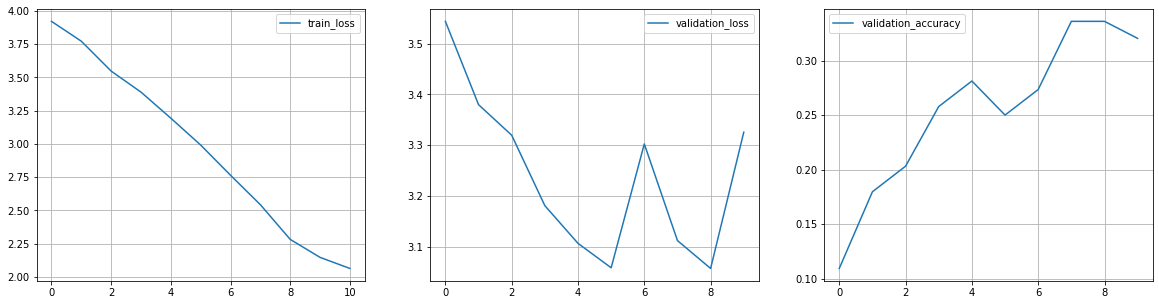

In [ ]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device, non_blocking=True)
        label = batch['label'].to(device, non_blocking=True)
        mel= featurizer(wav)
        output = model(mel)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(val_loader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        label = batch['label'].to(device)

        #with torch.no_grad():
        with torch.inference_mode(): # вместо no_grad усовершественная вещь 

            mel= featurizer(wav)
            output = model(mel)

            loss = criterion(output, label)
        
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()

In [ ]:
class AdvancedModel(nn.Module):
  def __init__(self, config:TaskConfig):
    super().__init__()
    self.config = config
    # block 1
    self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=config.cnn_out_channels,kernel_size=config.kernel_size, padding=1) # Conv2d(1, 8, kernel_size=(5, 20), stride=(1, 1), padding=(1, 1))
    self.conv1_2 = nn.Conv2d(in_channels = config.cnn_out_channels, out_channels =config.cnn_out_channels, kernel_size = config.kernel_size, padding=1)
    self.norm1 = nn.BatchNorm2d(config.cnn_out_channels)
    self.drop1 = nn.Dropout(0.2)

    # block 2
    self.conv2_1 = nn.Conv2d(in_channels=config.cnn_out_channels, out_channels=config.cnn_out_channels * 2,kernel_size=config.kernel_size, padding=1)
    self.conv2_2 = nn.Conv2d(in_channels = config.cnn_out_channels * 2, out_channels =config.cnn_out_channels * 2, kernel_size = config.kernel_size, padding=1)
    self.norm2 = nn.BatchNorm2d(config.cnn_out_channels * 2)
    self.drop2 = nn.Dropout(0.2)
    # block 3
    self.conv3_1 = nn.Conv2d(in_channels=config.cnn_out_channels * 2,out_channels=config.cnn_out_channels * 4,kernel_size=config.kernel_size, padding=1)
    self.conv3_2 = nn.Conv2d(in_channels = config.cnn_out_channels * 4, out_channels =config.cnn_out_channels * 4, kernel_size = config.kernel_size, padding=1)
    self.norm3 = nn.BatchNorm2d(config.cnn_out_channels * 4)
    self.drop3 = nn.Dropout(0.2)
    # block linear
    self.number = 9984
    self.pool = nn.MaxPool2d(2,2)
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(self.number, int(self.number / 4))
    self.norm4 = nn.BatchNorm1d(int(self.number / 4))
    self.drop4 = nn.Dropout(0.2)
    self.linear2 = nn.Linear(int(self.number / 4), int(self.number / 4 / 16))
    self.norm5 = nn.BatchNorm1d(int(self.number / 4 / 16))
    self.drop5 = nn.Dropout(0.5)
    self.linear3 = nn.Linear(int(self.number / 4 / 16), config.num_classes)
  
  def forward(self, batch):
    # first block
    batch = F.relu(self.norm1(self.conv1_1(batch.unsqueeze(dim=1))))
    batch = F.relu(self.norm1(self.conv1_2(batch)))
    batch = self.pool(batch)
    batch = self.drop1(batch)
    # second block
    batch = F.relu(self.norm2(self.conv2_1(batch)))
    batch = F.relu(self.norm2(self.conv2_2(batch)))
    batch = self.pool(batch)
    batch = self.drop2(batch)
    # third block
    batch = F.relu(self.norm3(self.conv3_1(batch)))
    batch = F.relu(self.norm3(self.conv3_2(batch)))
    batch = self.pool(batch)
    batch = self.drop3(batch)
    # flatten block
    batch = self.flatten(batch)
    # linear first block
    batch = self.norm4((self.linear1(batch)))
    batch = self.drop4(F.relu(batch))
    # linear second block
    batch = self.norm5((self.linear2(batch)))
    batch = self.drop5(F.relu(batch))
    # linear third block
    batch = self.linear3(batch)
    return batch


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
config = TaskConfig()
model = AdvancedModel(config).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=TaskConfig.learning_rate, weight_decay=TaskConfig.weight_decay)
criterion = nn.CrossEntropyLoss()
storage = defaultdict(list)
num_epoch = 10

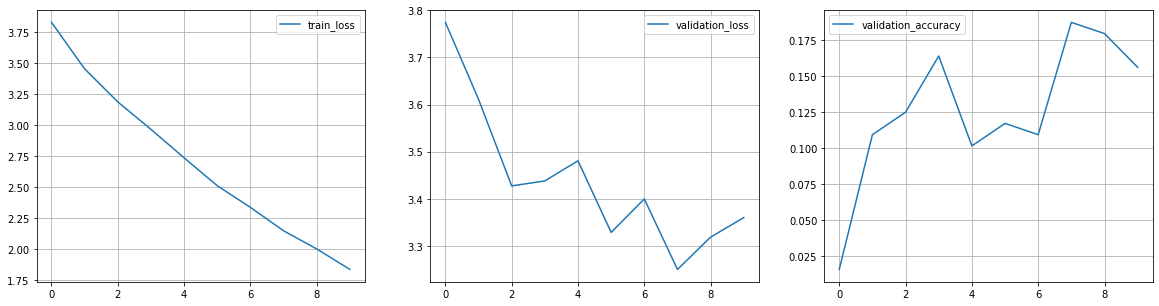

In [ ]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device, non_blocking=True)
        label = batch['label'].to(device, non_blocking=True)
        mel= featurizer(wav)
        output = model(mel)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(val_loader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        label = batch['label'].to(device)

        #with torch.no_grad():
        with torch.inference_mode(): # вместо no_grad усовершественная вещь 

            mel= featurizer(wav)
            output = model(mel)

            loss = criterion(output, label)
        
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()

In [ ]:
# Create by: https://github.com/anuragkr90/weak_feature_extractor

class Githubmodel(nn.Module):

    def __init__(self, config:TaskConfig):
        super(Githubmodel,self).__init__()
        self.config = config
        self.layer1 = nn.Sequential(nn.Conv2d(1,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv2d(16,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU())
        self.layer3 = nn.MaxPool2d(2)

        self.layer4 = nn.Sequential(nn.Conv2d(16,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(32,32,kernel_size=3,padding=1),nn.BatchNorm2d(32),nn.ReLU())
        self.layer6 = nn.MaxPool2d(2)

        self.layer7 = nn.Sequential(nn.Conv2d(32,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU())
        self.layer8 = nn.Sequential(nn.Conv2d(64,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU())
        self.layer9 = nn.MaxPool2d(2)

        self.layer10 = nn.Sequential(nn.Conv2d(64,128,kernel_size=3,padding=1),nn.BatchNorm2d(128),nn.ReLU())
        self.layer11 = nn.Sequential(nn.Conv2d(128,128,kernel_size=3,padding=1),nn.BatchNorm2d(128),nn.ReLU())
        self.layer12 = nn.MaxPool2d(2)

        self.layer13 = nn.Sequential(nn.Conv2d(128,256,kernel_size=3,padding=1),nn.BatchNorm2d(256),nn.ReLU())
        self.layer14 = nn.Sequential(nn.Conv2d(256,256,kernel_size=3,padding=1),nn.BatchNorm2d(256),nn.ReLU())
        self.layer15 = nn.MaxPool2d(2) #

        self.layer16 = nn.Sequential(nn.Conv2d(256,512,kernel_size=3,padding=1),nn.BatchNorm2d(512),nn.ReLU())
        # self.layer17 = nn.MaxPool2d(2) # 
        
        self.layer18 = nn.Sequential(nn.Conv2d(512,1024,kernel_size=2),nn.BatchNorm2d(1024),nn.ReLU())
        self.layer19 = nn.Sequential(nn.Conv2d(1024,config.num_classes,kernel_size=1),nn.Sigmoid())
        
        self.flatten = nn.Flatten()
        self.layer20 = nn.Linear(1250, config.num_classes)

    def forward(self,x):
        out = self.layer1(x.unsqueeze(dim=1))
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = self.layer14(out)
        out = self.layer15(out)
        out = self.layer16(out)
        #out = self.layer17(out)
        out = self.layer18(out)
        out1 = self.layer19(out)
        out1 = self.layer20(self.flatten(out1))
        #out = self.globalpool(out1,kernel_size=out1.size()[2:])
        #out = out.view(out.size(0),-1)
        return out1

In [ ]:
# a = next(iter(train_dataloader))['wav']
# featurizer = Featurizer()
# b = featurizer(a)
# b.shape

torch.Size([128, 64, 862])

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
config = TaskConfig()
model = Githubmodel(config).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=TaskConfig.learning_rate, weight_decay=TaskConfig.weight_decay)
criterion = nn.CrossEntropyLoss()
storage = defaultdict(list)
num_epoch = 10

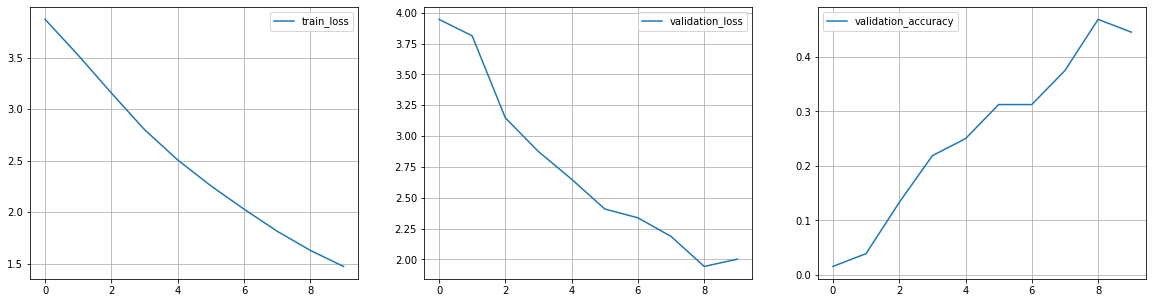

In [ ]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device, non_blocking=True)
        label = batch['label'].to(device, non_blocking=True)
        mel= featurizer(wav)
        output = model(mel)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(val_loader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        label = batch['label'].to(device)

        #with torch.no_grad():
        with torch.inference_mode(): # вместо no_grad усовершественная вещь 

            mel= featurizer(wav)
            output = model(mel)

            loss = criterion(output, label)
        
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()

In [ ]:
class Model(nn.Module):
    
    def __init__(self, input_dim, hidden_size):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, batch_first=True)
        self.clf = nn.Linear(hidden_size, 50)
    
    def forward(self, input, length=length):
        output, _ = self.rnn(input.transpose(-1, -2))   # mel shape [128, 862, 64] 
        last_hidden = torch.gather(
            output,
            dim=1,
            # substract 1 because index start from 0 (not 1 as length)
            index=length.sub(1).view(-1, 1, 1).expand(-1, -1, self.hidden_size)
        )
        logits = self.clf(last_hidden.squeeze(dim=1))
        
        return logits

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Model(input_dim=TaskConfig.n_mels, hidden_size=TaskConfig.batch_size).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=TaskConfig.learning_rate, weight_decay=TaskConfig.weight_decay)
criterion = nn.CrossEntropyLoss()

storage = defaultdict(list)
num_epoch = 10

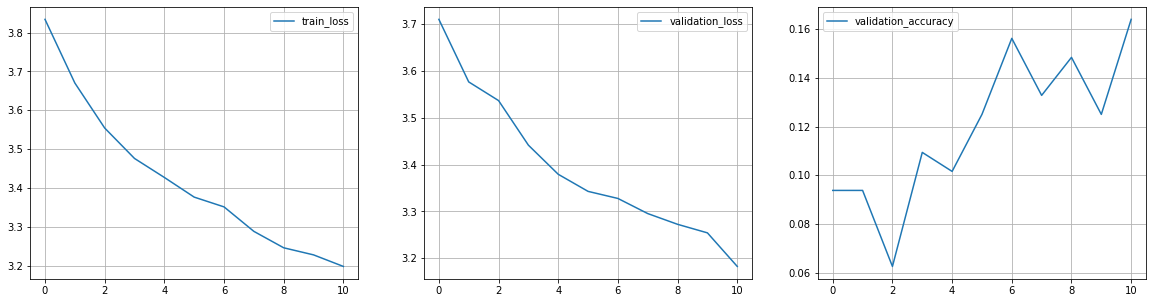

In [ ]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device, non_blocking=True)
        length = batch['length'].to(device, non_blocking=True)
        label = batch['label'].to(device, non_blocking=True)

        mel, mel_length = featurizer(wav, length)
        output = model(mel, mel_length)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(val_loader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        #with torch.no_grad():
        with torch.inference_mode(): # вместо no_grad усовершественная вещь 

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)

            loss = criterion(output, label)
        
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()

In [ ]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        ) # kernel_size - отвечает за размер свертки, out_channels - количество выходных каналов

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
config = TaskConfig()
model = CRNN(config).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=TaskConfig.learning_rate, weight_decay=TaskConfig.weight_decay)
criterion = nn.CrossEntropyLoss()
storage = defaultdict(list)
num_epoch = 10

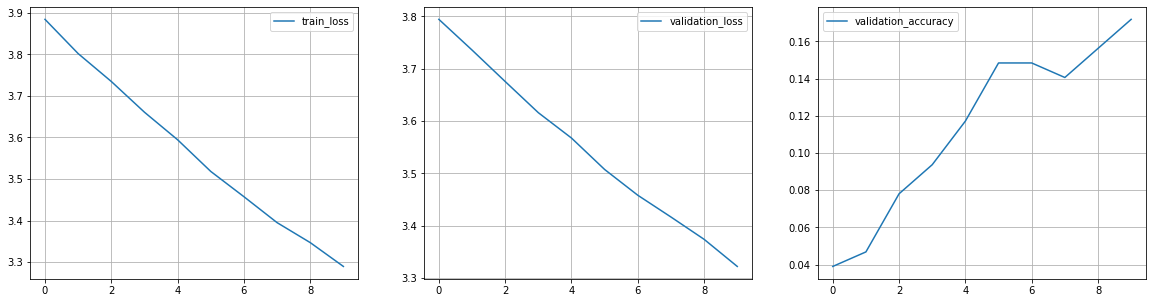

In [ ]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device, non_blocking=True)
        label = batch['label'].to(device, non_blocking=True)
        mel= featurizer(wav)
        output = model(mel)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(val_loader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        label = batch['label'].to(device)

        #with torch.no_grad():
        with torch.inference_mode(): # вместо no_grad усовершественная вещь 

            mel= featurizer(wav)
            output = model(mel)

            loss = criterion(output, label)
        
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()

In [15]:
from torchvision.models import vgg19

In [16]:
model = vgg19(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [17]:
for param in model.parameters():
    param.requires_grad = False

In [18]:
model.classifier[6] = nn.Linear(4096, TaskConfig.num_classes)
model.features[0] = nn.Conv2d(1, 64, kernel_size = (3,3), stride=(1, 1), padding=(1, 1))

In [19]:
model.features[0] = nn.Conv2d(1, 64, kernel_size = (3,3), stride=(1, 1), padding=(1, 1))

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
config = TaskConfig()
model.to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=TaskConfig.learning_rate, weight_decay=TaskConfig.weight_decay)
criterion = nn.CrossEntropyLoss()
storage = defaultdict(list)
num_epoch = 10

In [22]:
next(iter(train_dataloader))

{'wav': tensor([[-3.6566e-02, -4.0889e-02, -5.0206e-02,  ...,  1.0024e-02,
           3.0710e-02,  1.8007e-02],
         [ 9.4604e-04,  1.0529e-03,  1.0376e-03,  ..., -8.8120e-03,
          -9.2850e-03, -9.8190e-03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.6957e-02,
          -3.5675e-02, -1.6640e-02],
         ...,
         [ 5.9639e-03, -6.7561e-03, -3.2708e-04,  ...,  8.0727e-02,
           7.6897e-02,  7.6366e-02],
         [-1.5259e-04, -9.1553e-05, -3.0518e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 6.1939e-04,  1.1664e-03,  3.0050e-03,  ...,  2.5687e-03,
           2.8837e-04,  5.8698e-04]]),
 'label': tensor([ 4, 19, 39, 28, 24,  7, 30, 39, 43, 18, 18,  9, 13, 39,  5, 28,  5, 11,
         22, 33, 21, 45, 15, 14, 26, 49, 39, 25, 11, 26,  1, 44,  6, 20,  5, 27,
          1, 49, 10, 14, 49, 22,  7, 45, 36, 24,  2, 27,  8, 20, 17,  4, 45, 37,
         39,  3, 36, 43, 10, 32, 25, 37,  9, 25,  3, 28, 41,  6, 27, 20, 49, 10,
         30, 1

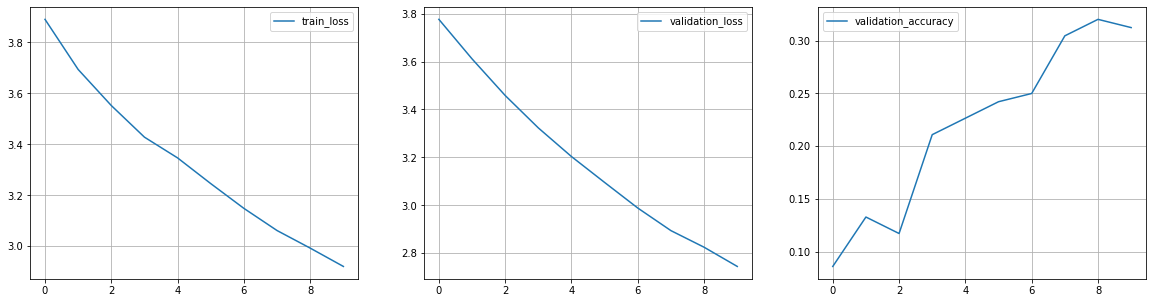

In [23]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device, non_blocking=True)
        label = batch['label'].to(device, non_blocking=True)
        mel= featurizer(wav)
        output = model(mel.unsqueeze(dim=1))

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(val_loader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        label = batch['label'].to(device)

        #with torch.no_grad():
        with torch.inference_mode(): # вместо no_grad усовершественная вещь 

            mel= featurizer(wav)
            output = model(mel.unsqueeze(dim=1))

            loss = criterion(output, label)
        
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
        
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()

In [ ]:
%debug

> /usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py(454)_conv_forward()
    452                             _pair(0), self.dilation, self.groups)
    453         return F.conv2d(input, weight, bias, self.stride,
--> 454                         self.padding, self.dilation, self.groups)
    455 
    456     def forward(self, input: Tensor) -> Tensor:

ipdb> u
> /usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py(457)forward()
    455 
    456     def forward(self, input: Tensor) -> Tensor:
--> 457         return self._conv_forward(input, self.weight, self.bias)
    458 
    459 class Conv3d(_ConvNd):

ipdb> u
> /usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py(1130)_call_impl()
   1128         if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks or _global_backward_hooks
   1129                 or _global_forward_hooks or _global_forward_pre_hooks):
-> 1130             return forward_call(*input, **kwargs)
   1131       